In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [50]:
from tensorflow import keras

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
print(tf.__version__)

2.6.0


In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
train_df = pd.read_csv('../data/train.csv', index_col=0)
val_df = pd.read_csv('../data/val.csv', index_col=0)
test_df = pd.read_csv('../data/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


# Chapter 13 

## 13.1 Creating windows of data
### 13.1.1 Exploring how deep learning models are trained for time series forecasting

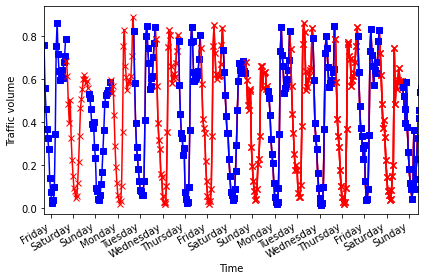

In [6]:
fig, ax = plt.subplots()

for n in range(0,17,2):
    start = 24*n
    stop = 24*(n+1)
    ax.plot(train_df.traffic_volume[start:stop], marker='s', color='blue', label='input')
    ax.plot(train_df.traffic_volume[stop:2*stop], marker='x', color='red', label='label')
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/CH13_F01_peixeiro.png', dpi=300)

여기서 데이터 윈도우는 24시간을 데이터를 사용해서, 다음 24시간을 예측한다.

윈도우는 입력 24, 출력 24로 되어있다. 따라서 전체 길이는 48이다.

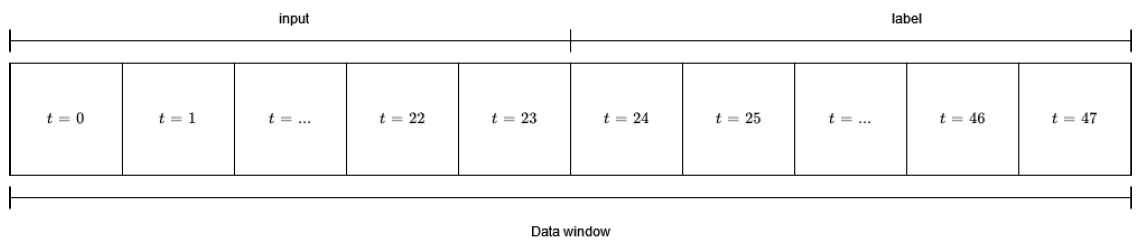

다음 샘플 윈도우는 t=1부터 시작한다.

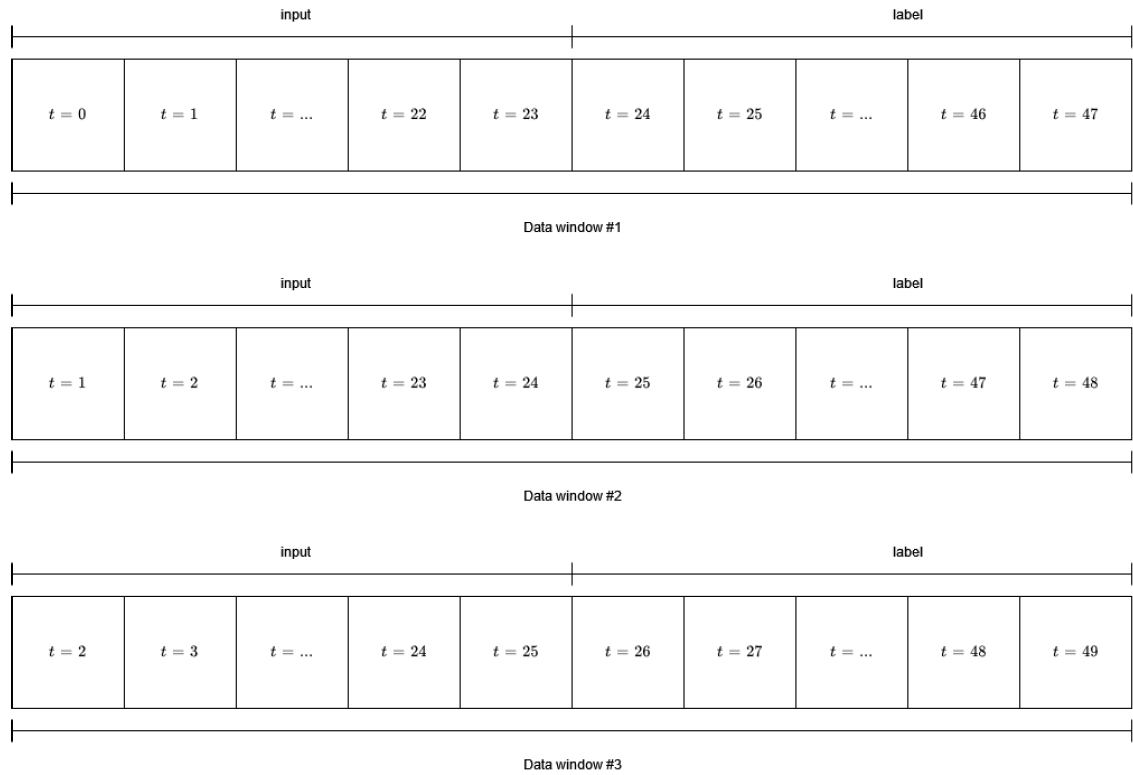

그리고 계산을 보다 효율적으로 하기위해 배치를 만든다.

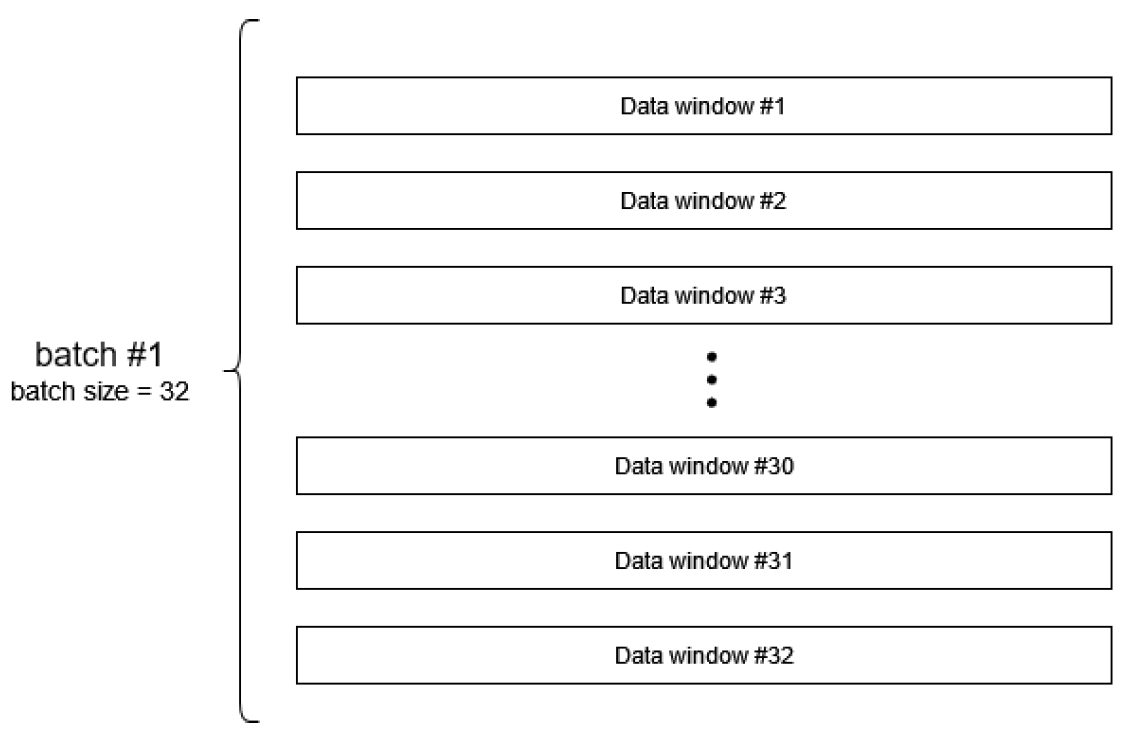

마지막으로 셔플링을 진행한다.  
시계열은 셔플링하면 안되지만 배치 안에서는 가능하다.

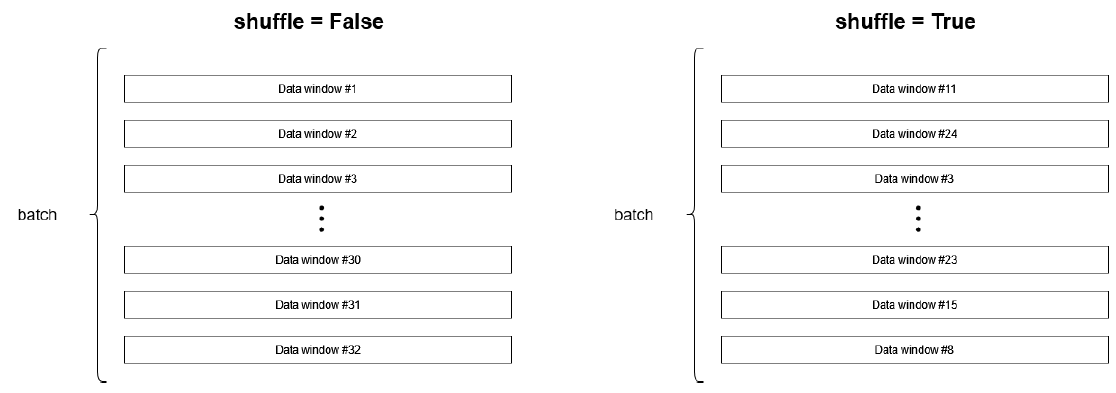

### 13.1.2 Implementing the `DataWindow` class 

저장되는 데이터의 개념

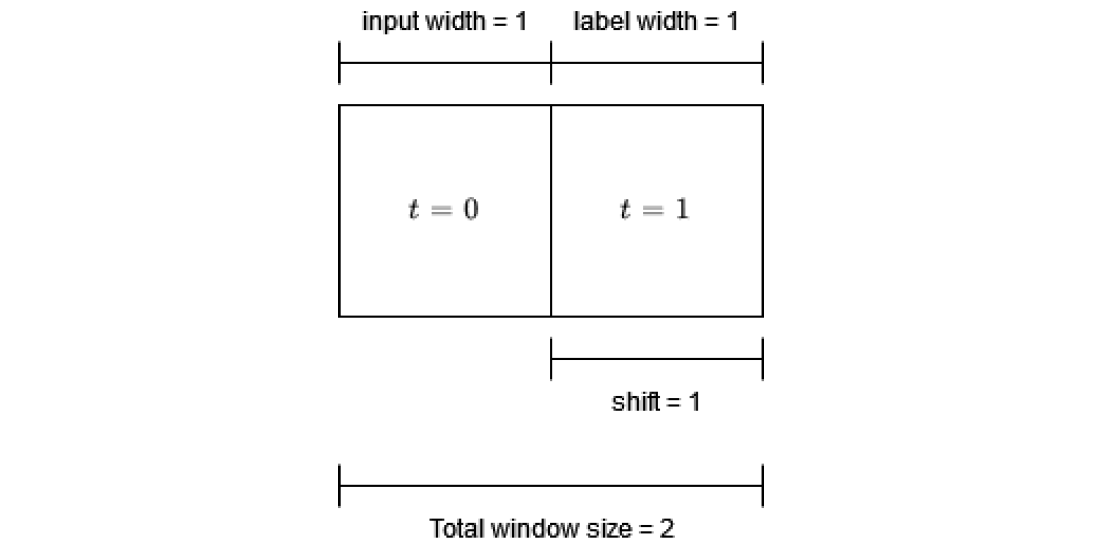

- 여기서 shift는 1인데 바로 다음 스텝의 값을 예측하기 때문에??

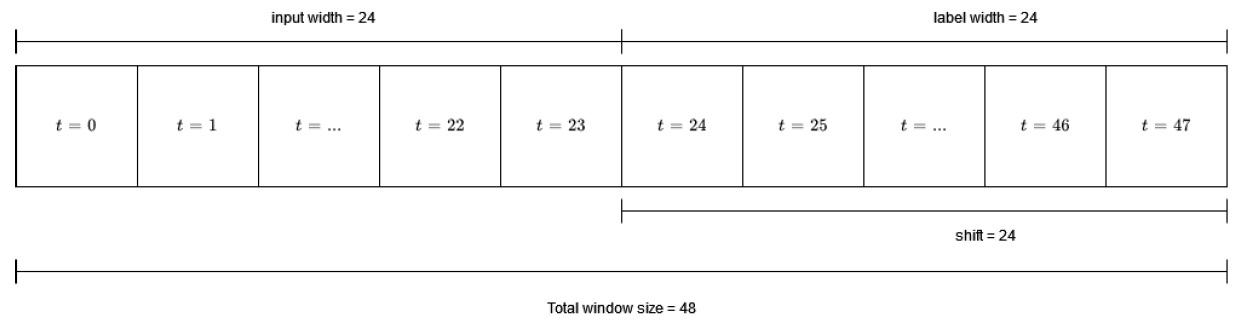

- 24 step의 뒤를 예측하므로 shift는 24

In [7]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, train_df = train_df, val_df= val,
                 test_df = test_df, label_columns = None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns # 예측하고자 하는 컬럼의 이름
        if label_columns is not None:
            self.label_columns_indice = {name : i for i, name in enumerate(label_columns)} # 플롯팅을 위해 라벨이름과 인덱스 번호로 딕셔너리 만듬
            
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)} # 학습 데이터 컬럼
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width) # 0~인풋길이 만큼 슬라이싱을 위한 인덱스 생성
        self.input_indices = np.arange(self.total_window_size)[self.input_slice] # 입력 부분 인덱스
        
        self.label_start = self.total_window_size - self.label_width
        
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels

NameError: name 'val' is not defined

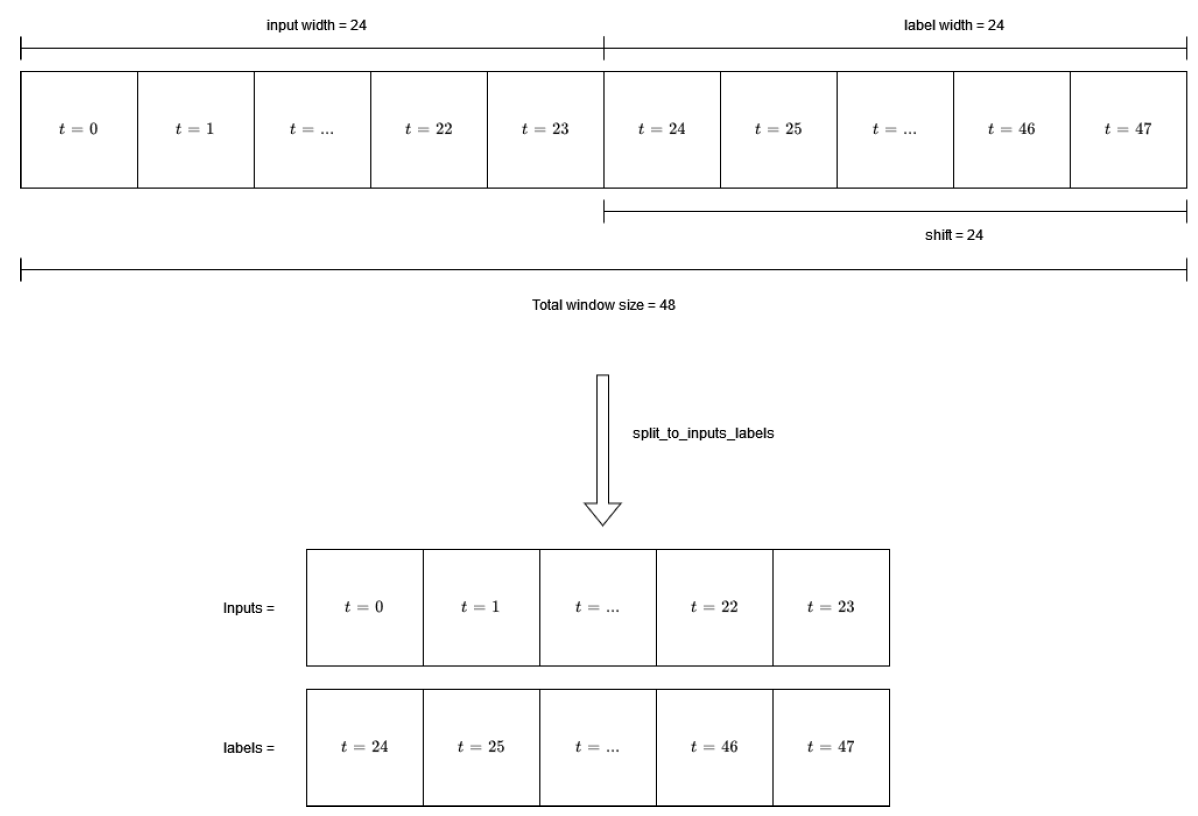

- split_to_inputs_labels 함수 실행 결과

In [7]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col] # 그릴 컬럼의 인덱스
        max_n = min(max_subplots, len(inputs)) # 
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data): # 데이터셋을 텐서로 만드는 로직
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,# 학습, 시험, 검증과 같은 데이터 입력
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

## 13.2 Applying baseline models
### 13.2.1 Single-step baseline model

In [8]:
train_df.head()

,temp,clouds_all,traffic_volume,day_sin,day_cos
0,0.760019,0.0,0.758755,0.146447,0.853553
1,0.738174,0.0,0.560765,0.250000,0.933013
2,0.698884,0.0,0.463513,0.370590,0.982963
3,0.668238,0.0,0.370029,0.500000,1.000000
4,0.643093,0.0,0.325101,0.629410,0.982963


In [17]:
a = [[[1, 2, 3], [4, 5, 6], [7, 8, 9]], 
[[1, 2, 3], [4, 5, 6], [7, 8, 9]],
[[1, 2, 3], [4, 5, 6], [7, 8, 9]],]

In [26]:
b = np.array(a)

In [27]:
b[:, :, 1]

array([[2, 5, 8],
       [2, 5, 8],
       [2, 5, 8]])

In [28]:
b

array([[[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]],

       [[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]],

       [[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]])

In [29]:
val_df

,temp,clouds_all,traffic_volume,day_sin,day_cos
12285,0.457646,0.01,0.700153,0.017037,0.629410
12286,0.460946,0.20,0.769918,0.066987,0.750000
12287,0.459375,0.05,0.872750,0.146447,0.853553
12288,0.456388,0.20,0.776894,0.250000,0.933013
12289,0.440830,0.05,0.664574,0.370590,0.982963
...,...,...,...,...,...
15790,0.805595,0.90,0.780103,0.017037,0.629410
15791,0.796637,0.90,0.885447,0.066987,0.750000
15792,0.794437,0.90,0.803544,0.146447,0.853553
15793,0.783121,0.90,0.611692,0.250000,0.933013


single step모델과 wide step 데이터를 만들어 보자.

In [9]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume']) 
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

가장 간단한 예측법인 이전 값을 결과로 출력하는 모델을 만들자.

In [10]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index # 타겟 이름 지정
        
    def call(self, inputs):
        if self.label_index is None: # 타겟 이 지정 되지 않으면 모든 컬럼을 리턴
            return inputs
        
        elif isinstance(self.label_index, list):# 
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [11]:
column_indices = {name: i for i, name in enumerate(train_df.columns)} # 학습 데이터의 컬럼 딕셔

baseline_last = Baseline(label_index=column_indices['traffic_volume'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [12]:
single_step_window.val.

<MapDataset shapes: ((None, 1, 5), (None, 1, 1)), types: (tf.float32, tf.float32)>

In [13]:
val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

110/110 [==============================] - 1s 4ms/step - loss: 0.0133 - mean_absolute_error: 0.0831


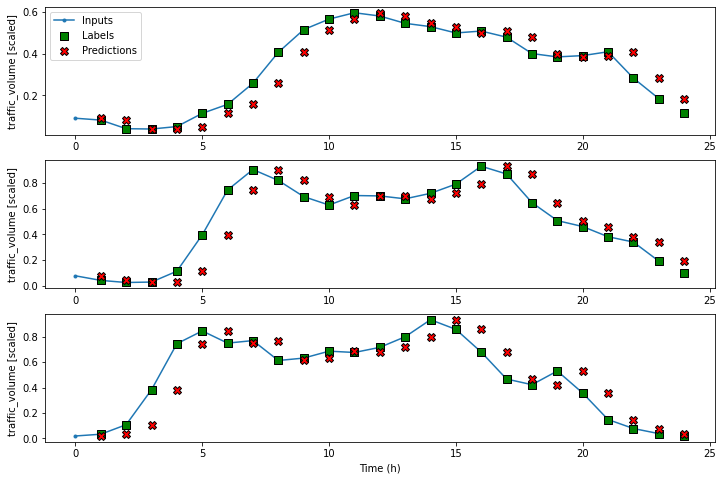

In [14]:
wide_window.plot(baseline_last)

plt.savefig('figures/CH13_F09_peixeiro.png', dpi=300)

In [14]:
print(performance['Baseline - Last'][1])

0.08128400146961212


### 13.2.2 Multi-step baseline models 

24시간 입력으로 24 스텝을 예측하는 모델. 단 기존 상태 유지

In [31]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

#### Predicting the last known value 

In [30]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1]) # label index가 없으면 모든 컬럼 정보의 마지막 값을 24step 길이만큼 연속으로 붙임
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1]) # 타겟 컬럼의 마지막 값을 24 step만큼 붙임

In [32]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 1s 3ms/step - loss: 0.1875 - mean_absolute_error: 0.3522


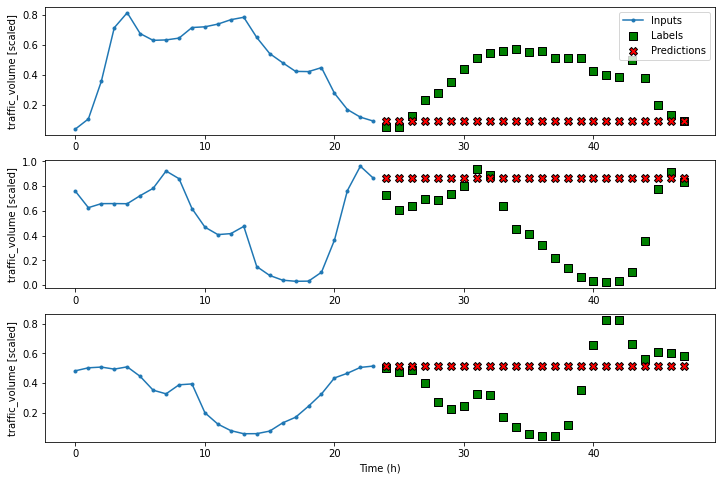

In [33]:
multi_window.plot(ms_baseline_last)

plt.savefig('figures/CH13_F10_peixeiro.png', dpi=300)

In [34]:
print(ms_performance['Baseline - Last'][1])

0.3472606837749481


#### Repeating the input sequence 

In [35]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [36]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 1s 4ms/step - loss: 0.2065 - mean_absolute_error: 0.3473


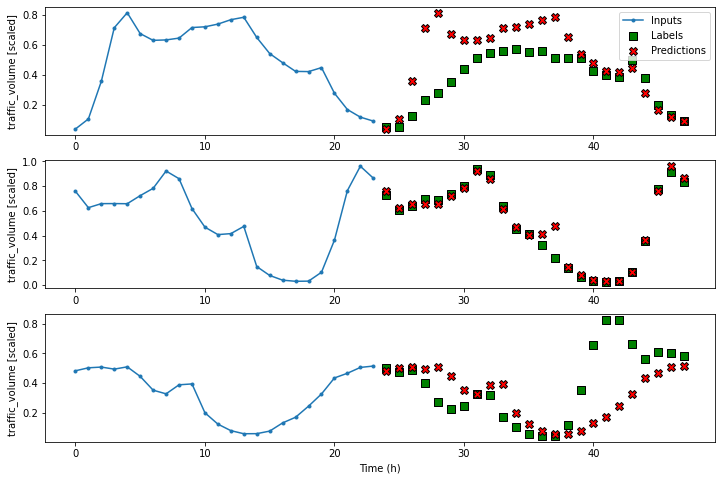

In [37]:
multi_window.plot(ms_baseline_repeat)

plt.savefig('figures/CH13_F11_peixeiro.png', dpi=300)

In [38]:
print(ms_performance['Baseline - Repeat'][1])

0.3412770926952362


### 13.2.3 Multi-output baseline model 

In [39]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume']) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

In [40]:
print(column_indices['traffic_volume'])
print(column_indices['temp'])

2
0


In [41]:
mo_baseline_last = Baseline(label_index=[0, 2])

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

109/109 [==============================] - 1s 4ms/step - loss: 0.0069 - mean_absolute_error: 0.0482


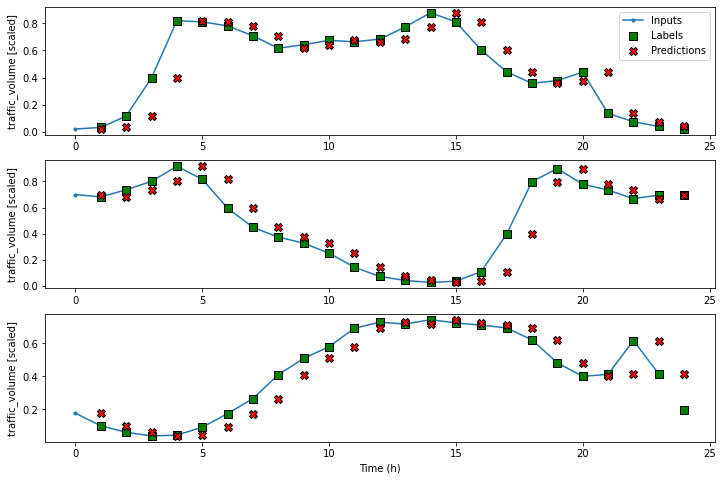

In [42]:
mo_wide_window.plot(mo_baseline_last)

plt.savefig('figures/CH13_F12_peixeiro.png', dpi=300)

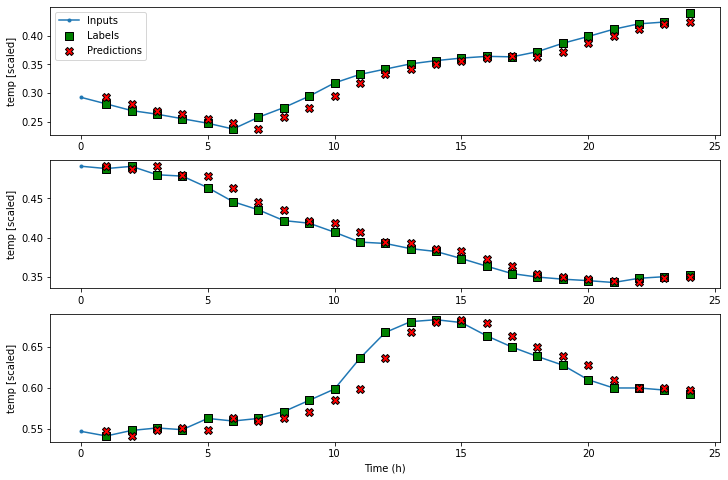

In [43]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='temp')

plt.savefig('figures/CH13_F13_peixeiro.png', dpi=300)

In [44]:
print(mo_performance['Baseline - Last'][1])

0.04710667207837105


# Chapter 14 

## 14.1 Implementing a linear model
### 14.1.1 Building a single-step linear model

In [45]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [46]:
linear = Sequential([
    Dense(units=1)
])

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 2s 2ms/step - loss: 0.3947 - mean_absolute_error: 0.5133 - val_loss: 0.1106 - val_mean_absolute_error: 0.2758
Epoch 2/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0950 - mean_absolute_error: 0.2541 - val_loss: 0.0674 - val_mean_absolute_error: 0.2116
Epoch 3/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0577 - mean_absolute_error: 0.1963 - val_loss: 0.0432 - val_mean_absolute_error: 0.1693
Epoch 4/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0375 - mean_absolute_error: 0.1576 - val_loss: 0.0306 - val_mean_absolute_error: 0.1427
Epoch 5/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0268 - mean_absolute_error: 0.1329 - val_loss: 0.0238 - val_mean_absolute_error: 0.1254
Epoch 6/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0209 - mean_absolute_error: 0.1163 - val_loss: 0.0195 - val_mean_absolute_error: 0.1127
Epoch 7/50
384/3

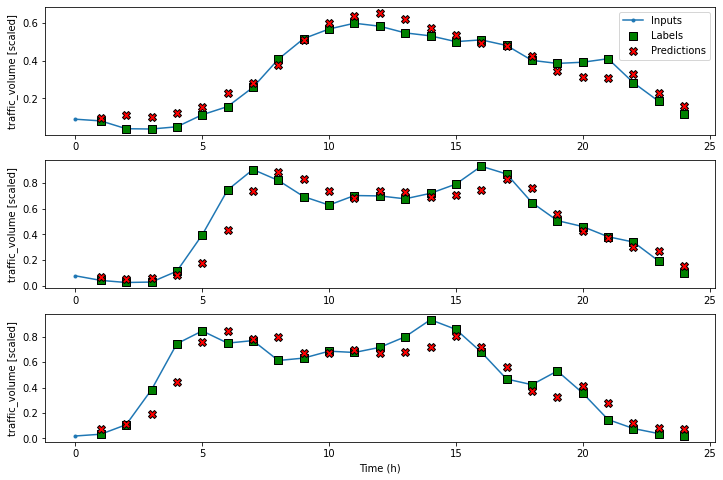

In [48]:
wide_window.plot(linear)

plt.savefig('figures/CH14_F02_peixeiro.png', dpi=300)

### 14.1.2 Building a mutli-step linear model 

In [52]:
ms_linear = Sequential([
    Dense(1, kernel_initializer=tf.keras.initializers.zeros)
])

history = compile_and_fit(ms_linear, multi_window)

ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_performance['Linear'] = ms_linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 1s 3ms/step - loss: 0.0896 - mean_absolute_error: 0.2462 - val_loss: 0.0457 - val_mean_absolute_error: 0.1821
Epoch 2/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0298 - mean_absolute_error: 0.1366 - val_loss: 0.0262 - val_mean_absolute_error: 0.1259
Epoch 3/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0200 - mean_absolute_error: 0.1043 - val_loss: 0.0213 - val_mean_absolute_error: 0.1083
Epoch 4/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0176 - mean_absolute_error: 0.0954 - val_loss: 0.0197 - val_mean_absolute_error: 0.1007
Epoch 5/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0168 - mean_absolute_error: 0.0913 - val_loss: 0.0189 - val_mean_absolute_error: 0.0964
Epoch 6/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0164 - mean_absolute_error: 0.0887 - val_loss: 0.0185 - val_mean_absolute_error: 0.0933
Epoch 7/50
383/3

### 14.1.3 Implementing a multi-output linear model 

In [53]:
mo_linear = Sequential([
    Dense(units=2)
])

history = compile_and_fit(mo_linear, mo_single_step_window)

mo_val_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.val)
mo_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 1s 3ms/step - loss: 0.1034 - mean_absolute_error: 0.2490 - val_loss: 0.0578 - val_mean_absolute_error: 0.1835
Epoch 2/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0398 - mean_absolute_error: 0.1495 - val_loss: 0.0275 - val_mean_absolute_error: 0.1237
Epoch 3/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0196 - mean_absolute_error: 0.1050 - val_loss: 0.0149 - val_mean_absolute_error: 0.0924
Epoch 4/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0115 - mean_absolute_error: 0.0806 - val_loss: 0.0096 - val_mean_absolute_error: 0.0742
Epoch 5/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0081 - mean_absolute_error: 0.0661 - val_loss: 0.0071 - val_mean_absolute_error: 0.0621
Epoch 6/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0066 - mean_absolute_error: 0.0572 - val_loss: 0.0060 - val_mean_absolute_error: 0.0546
Epoch 7/50
384/3

## 14.2 Implementing a deep neural network
### 14.2.1 Implementing a deep neural network as a single-step model

In [54]:
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 2s 3ms/step - loss: 0.0215 - mean_absolute_error: 0.0879 - val_loss: 0.0046 - val_mean_absolute_error: 0.0517
Epoch 2/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0046 - mean_absolute_error: 0.0504 - val_loss: 0.0035 - val_mean_absolute_error: 0.0447
Epoch 3/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0039 - mean_absolute_error: 0.0463 - val_loss: 0.0033 - val_mean_absolute_error: 0.0440
Epoch 4/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0036 - mean_absolute_error: 0.0436 - val_loss: 0.0032 - val_mean_absolute_error: 0.0423
Epoch 5/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0034 - mean_absolute_error: 0.0424 - val_loss: 0.0029 - val_mean_absolute_error: 0.0394
Epoch 6/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0032 - mean_absolute_error: 0.0413 - val_loss: 0.0028 - val_mean_absolute_error: 0.0393
Epoch 7/50
384/3

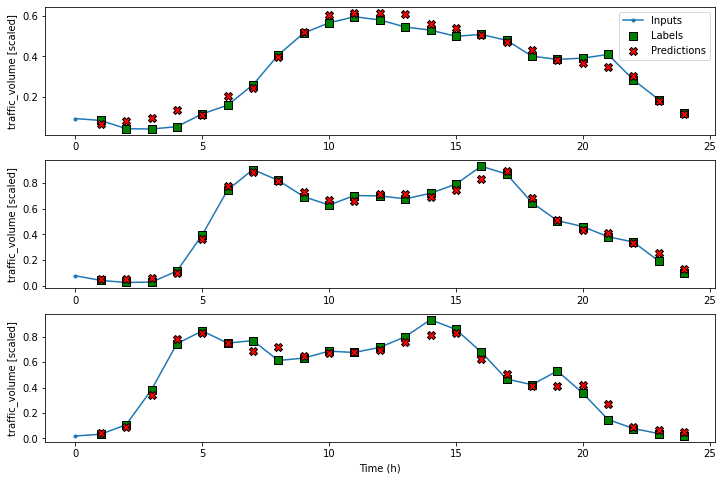

In [55]:
wide_window.plot(dense)

plt.savefig('figures/CH14_F06_peixeiro.png', dpi=300)

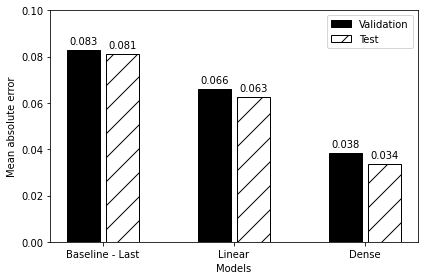

In [56]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH14_F07_peixeiro.png', dpi=300)

### 14.2.2 Implementing a deep neural network as a multi-step model 

In [59]:
ms_dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.keras.initializers.zeros),
])

history = compile_and_fit(ms_dense, multi_window)

ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_performance['Dense'] = ms_dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 2s 3ms/step - loss: 0.0302 - mean_absolute_error: 0.1106 - val_loss: 0.0163 - val_mean_absolute_error: 0.0828
Epoch 2/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0138 - mean_absolute_error: 0.0777 - val_loss: 0.0152 - val_mean_absolute_error: 0.0796
Epoch 3/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0133 - mean_absolute_error: 0.0768 - val_loss: 0.0149 - val_mean_absolute_error: 0.0822
Epoch 4/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0132 - mean_absolute_error: 0.0765 - val_loss: 0.0152 - val_mean_absolute_error: 0.0849
Epoch 5/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0131 - mean_absolute_error: 0.0761 - val_loss: 0.0147 - val_mean_absolute_error: 0.0797
Epoch 6/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0129 - mean_absolute_error: 0.0755 - val_loss: 0.0145 - val_mean_absolute_error: 0.0793
Epoch 7/50
383/3

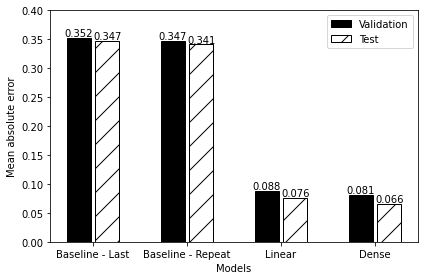

In [60]:
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]

x = np.arange(len(ms_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=ms_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH14_F08_peixeiro.png', dpi=300)

### 14.2.3 Implementing a deep neural network as a multi-output model 

In [61]:
mo_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_dense, mo_single_step_window)

mo_val_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.val)
mo_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0139 - mean_absolute_error: 0.0663 - val_loss: 0.0033 - val_mean_absolute_error: 0.0357
Epoch 2/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0032 - mean_absolute_error: 0.0355 - val_loss: 0.0027 - val_mean_absolute_error: 0.0332
Epoch 3/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0028 - mean_absolute_error: 0.0324 - val_loss: 0.0026 - val_mean_absolute_error: 0.0350
Epoch 4/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0024 - mean_absolute_error: 0.0303 - val_loss: 0.0018 - val_mean_absolute_error: 0.0281
Epoch 5/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0021 - mean_absolute_error: 0.0284 - val_loss: 0.0018 - val_mean_absolute_error: 0.0273
Epoch 6/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0021 - mean_absolute_error: 0.0283 - val_loss: 0.0017 - val_mean_absolute_error: 0.0276
Epoch 7/50
384/3

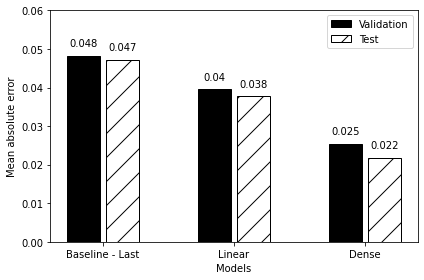

In [62]:
mo_mae_val = [v[1] for v in mo_val_performance.values()]
mo_mae_test = [v[1] for v in mo_performance.values()]

x = np.arange(len(mo_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=mo_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH14_F09_peixeiro.png', dpi=300)